<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> INTRODUCTION</p>

This notebook aims to show some audio treatments that were used in the BIRDCLEF-2022 Competition.

We use this code to treat the sounds of birds, minimizing noise and interference. At the end of the treated audio, we added some noises such as pink noise, white noise, etc.

We followed the steps mentioned in the figure.
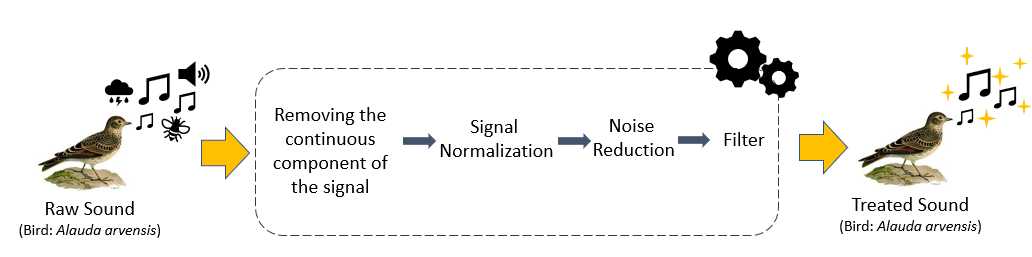

We leave the code below.

Enjoy :)

<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> LIBRARIES</p>

In [ ]:
!pip install noisereduce -q
!pip install colorednoise -q

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                                    LIBRARIES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Matrix and Arrays
import numpy as np
import pandas as pd

# Random
import random

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Signal
import scipy
from scipy.fftpack import rfft, irfft, fftfreq, fft
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt
from scipy.signal import hilbert
from scipy.io.wavfile import write

# Audio
import librosa
import librosa.display
import IPython.display as ipd
import noisereduce as nr
import soundfile as sf

# Sklearn
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, train_test_split

# Pytorch
import torch
import torchaudio

# Math
from math import ceil

# Files
import os
import json

from tqdm.auto import tqdm
# from tqdm import tqdm
from functools import partial
from joblib import Parallel, delayed

# Warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                                    ENVIRONMENT
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

manualSeed = 42

print('[INFO] Random Seed:', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


print('[INFO] Training Mode:')
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('\t->  Training on CPU')
    device = torch.device('cpu')
else:
    print('\t-> Training on GPU')
    device = torch.device('cuda')
    torch.cuda.empty_cache()

<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> CONFIGURATION CLASS</p>

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                                    CONFIG
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class CONFIG:
  # Paths
  path_main = '../input/birdclef-2022'
  path_output = './'
  path_audio = '../input/birdclef-2022/train_audio'

  # Filter parameters (take the whole base or not)
  prop = 1

  # Audio Treatment Parameters
  sr = 22050
  n_fft = 2048
  win_length = 512
  lowcut = 955
  highcut = 7005
  order = 5

  # Noise Parameters
  white = True
  pink = True
  blue = True
  violet = True
  brownian = False
  alpha = 35
  beta = 5

  # Test
  test = True
  n = 5
  
  # Audio times
  time_max = 300 # 10 minutes
  time_min = 1 # 1 seconds

  # Save Parameters
  audio_extension = '.wav'

<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> DATA</p>

In [ ]:
print(f'[INFO] Files list:')
os.listdir(CONFIG.path_main)

In [ ]:
train_meta = pd.read_csv(os.path.join(CONFIG.path_main, 'train_metadata.csv'))
test_data = pd.read_csv(os.path.join(CONFIG.path_main,'test.csv'))
ebird_data = pd.read_csv(os.path.join(CONFIG.path_main, 'eBird_Taxonomy_v2021.csv'))
samp_subm = pd.read_csv(os.path.join(CONFIG.path_main, 'sample_submission.csv'))


with open(os.path.join(CONFIG.path_main, 'scored_birds.json')) as f:
    scored_birds = json.load(f)


train_meta_filtered = train_meta[train_meta.primary_label.isin(scored_birds)]\
                                 .reset_index()\
                                 .drop('index', axis=1)

train_meta_rest = train_meta[~train_meta.primary_label.isin(scored_birds)]\
                                 .reset_index()\
                                 .drop('index', axis=1)      

if CONFIG.prop > 0.0 and CONFIG.prop != 1:
   _, base, _, _ = train_test_split(train_meta_rest, 
                                    train_meta_rest.primary_label,
                                    test_size = CONFIG.prop, 
                                    random_state = manualSeed, 
                                    stratify = train_meta_rest.primary_label)
   train_meta_filtered = pd.concat([train_meta_filtered, base], 
                                   ignore_index = True)
if CONFIG.prop == 0:
   train_meta_filtered = pd.concat([train_meta_filtered, train_meta_rest], 
                                   ignore_index = True)

     
print('[INFO] Main information:')
print('\t-> Number of birds to be scored:', len(scored_birds))
print('\t-> Training Base:', train_meta.shape)
print('\t\t-> Total Classes:', len(train_meta.primary_label.unique()))
print('\t-> Filtered Training Base:', train_meta_filtered.shape)
print('\t\t-> Filtered Total Classes:', len(train_meta_filtered.primary_label.unique()))
print('\t-> Test Base:',test_data.shape)


In [ ]:
train_meta_filtered[train_meta_filtered.primary_label == 'skylar'].head()

<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> AUDIO TREATMENTS</p>

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                        FUNCTIONS NECESSARY FOR SIGNAL TREATMENT
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def Main_Parameters(y_t, sr):
  """Function to get the main characteristics of the signal"""
  N = len(y_t)                                      # number of samples
  T = 1.0 / sr                                      # data period
  x_t = np.linspace(0.0, N*T, N)                    # time
  x_f = np.linspace(0.0, 1.0/(2.0*T), int(N/2))     # frequency 
  return N, T, x_t, x_f

#********************************************************************************************

def Removing_Component_Continue(y_t):
  """Function to remove continuous component from the signal"""
  mean_y = np.mean(y_t)
  y_ = y_t - mean_y
  return y_

#********************************************************************************************

def Normalization_Signal(y_t):
  """Function to put the sign between -1 and 1"""
  max_y = np.max(y_t)
  y_ = y_t/max_y
  return y_

#********************************************************************************************

def Reduction_Noise(y_t, sr, n_fft, win_length, use_tqdm = False, norm = False):
  """Function to reduce signal noise amplitudes"""
  y_ = nr.reduce_noise(y = y_t,
                      sr = sr,
                      n_fft = n_fft,
                      win_length = win_length,
                      use_tqdm = use_tqdm,
                      n_jobs = 2)
  y_ = np.array(y_)
  if norm:
    y_ = Normalization_Signal(y_)
  return y_

#********************************************************************************************

def Band_Pass_Filter(y_t, sr, lowcut, highcut, order):
  """Band pass filter"""
  nyq = 0.5 * sr
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='bandpass', analog=False, output='ba')
  y_ = filtfilt(b, a, y_t)
#     sos = butter(order, normal_cutoff , analog=False, btype='lowpass', output='sos')
#     y = sosfilt(sos, data)
  return y_

#********************************************************************************************

def Envelope(y_t, plot):
  """Hilbert transform"""
  analytical_signal = hilbert(y_t)
  y_ = np.abs(analytical_signal)
  if plot == True:
    hilbert_fft = fft(y_)
  else:
    hilbert_fft = 0
  return y_, hilbert_fft


In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                             FULL SIGNAL FUNCTION
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def Complete_Treatment(y_t, sr, 
                        n_fft = CONFIG.n_fft, 
                        win_length = CONFIG.win_length, 
                        use_tqdm = True,
                        low = CONFIG.lowcut,
                        high = CONFIG.highcut,
                        ord = CONFIG.order,
                        plot = True, 
                        nome = None):
  """ Complete signal processing"""
  N, T, x_t, x_f = Main_Parameters(y_t, sr)
  if plot:
    y_f_0 = fft(y_t)
  
  y_1 = Removing_Component_Continue(y_t)
  if plot:
    y_f_1 = fft(y_1)
    
  y_2 = Normalization_Signal(y_1)
  if plot:
    y_f_2 = fft(y_2)   

  y_3 = Reduction_Noise(y_2, 
                       sr, 
                       n_fft = n_fft, 
                       win_length = win_length, 
                       use_tqdm = use_tqdm,
                       norm = True)
  if plot:
    y_f_3 = fft(y_3)  
    
  y_4 = Band_Pass_Filter(y_3, sr, 
                           lowcut = low, 
                           highcut = high, 
                           order = ord)
  if plot:
    y_f_4 = fft(y_4)
        
  y_5, y_f_5 = Envelope(y_4, plot = plot)
    
  if plot:
    fig, ax = plt.subplots(figsize =(15,12), nrows = 6, ncols = 2)
    if nome == None:
      fig.suptitle('Signal treatments')
    else:
      fig.suptitle(f'Signal treatments - bird: {nome}')    

    ax[0, 0].plot(x_t, y_t)
    ax[0, 0].set_title('Raw Data')
    ax[0, 0].set_xlabel('t (s)')   
    ax[0, 1].plot(x_f, 2.0/N * np.abs(y_f_0[:N//2]))
    ax[0, 1].set_title('Frequency')
    ax[0, 1].set_xlabel('Hz')
        
    ax[1, 0].plot(x_t, y_1)
    ax[1, 0].set_title('Data without Continuous Component')
    ax[1, 0].set_xlabel('t (s)')   
    ax[1, 1].plot(x_f, 2.0/N * np.abs(y_f_1[:N//2]))
    ax[1, 1].set_title('Frequency')
    ax[1, 1].set_xlabel('Hz')  
        
    ax[2, 0].plot(x_t, y_2)
    ax[2, 0].set_title('Normalized Data')
    ax[2, 0].set_xlabel('t (s)')   
    ax[2, 1].plot(x_f, 2.0/N * np.abs(y_f_2[:N//2]))
    ax[2, 1].set_title('Frequency')
    ax[2, 1].set_xlabel('Hz')  
        
    ax[3, 0].plot(x_t, y_3)
    ax[3, 0].set_title('Data with Noise Reduction')
    ax[3, 0].set_xlabel('t (s)')   
    ax[3, 1].plot(x_f, 2.0/N * np.abs(y_f_3[:N//2]))
    ax[3, 1].set_title('Frequências')
    ax[3, 1].set_xlabel('Hz')  
        
    ax[4, 0].plot(x_t, y_4)
    ax[4, 0].set_title('Filtered Data')
    ax[4, 0].set_xlabel('t (s)')   
    ax[4, 1].plot(x_f, 2.0/N * np.abs(y_f_4[:N//2]))
    ax[4, 1].set_title('Frequency')
    ax[4, 1].set_xlabel('Hz')
        
    ax[5, 0].plot(x_t, y_5)
    ax[5, 0].set_title('Envelope')
    ax[5, 0].set_xlabel('t (s)')   
    ax[5, 1].plot(x_f, 2.0/N * np.abs(y_f_5[:N//2]))
    ax[5, 1].set_title('Frequency')
    ax[5, 1].set_xlabel('Hz')
        
    plt.subplots_adjust(wspace = 0.2, hspace = 0.8)
    plt.show()
        
  return y_5, y_4, x_t

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                             NOISE FUNCTIONS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#https://stackoverflow.com/questions/67085963/generate-colors-of-noise-in-python

def noise_psd(N, psd = lambda f: 1):
  X_white = np.fft.rfft(np.random.randn(N));
  S = psd(np.fft.rfftfreq(N))
  S = S / np.sqrt(np.mean(S**2))
  X_shaped = X_white * S;
  return np.fft.irfft(X_shaped);

#********************************************************************************************

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

#********************************************************************************************

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                             NOISE ADD FUNCTIONS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def Add_Noise(y_t, N, 
              white = CONFIG.white, 
              pink = CONFIG.pink, 
              blue = CONFIG.blue,
              violet = CONFIG.violet, 
              brownian = CONFIG.brownian, 
              alpha = CONFIG.alpha,  beta = CONFIG.beta):
  """ NOISE ADD FUNCTIONS"""
  new_signals = []
  d = {}
  index = 0

  if white:
    # noise = np.random.normal(loc=0, scale=1, size=N)
    noise = white_noise(N+5)
    y = y_t + noise[:len(y_t)]/alpha
    new_signals.append(y)
    index += 1
    d[index] = 'white_noise'

  if pink:
    noise = pink_noise(N+5)
    y = y_t + noise[:len(y_t)]/alpha
    new_signals.append(y)
    index += 1
    d[index] = 'pink_noise'

  if blue:
    noise = blue_noise(N+5)
    y = y_t + noise[:len(y_t)]/alpha
    new_signals.append(y)
    index += 1
    d[index] = 'blue_noise'

  if violet:
    noise = violet_noise(N+5)
    y = y_t + noise[:len(y_t)]/alpha
    new_signals.append(y)
    index += 1
    d[index] = 'violet_noise'

#   if brownian:
#     noise = brownian_noise(N+5)
#     y = y_t + noise[:len(y_t)]*beta
#     new_signals.append(y)
#     index += 1
#     d[index] = 'brownian_noise'

  return new_signals, d


<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> TEST</p>

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                               TEST
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

if CONFIG.test:
  for i in range(CONFIG.n):
    path_audio = CONFIG.path_audio
    n = np.random.randint(0, len(train_meta_filtered))
    audio = train_meta_filtered.filename.values[n]
    bird = train_meta_filtered.primary_label.values[n]
    
    print(f'\n\n\n                         ############## EXEMPLE {n} ##############')

    y_t, sr = librosa.load(os.path.join(path_audio, audio)) 
        
    _, y_trat, x_t = Complete_Treatment(y_t, 
                                        sr, 
                                        plot = True, 
                                        nome = bird)  

    N, T, x_t, x_f = Main_Parameters(y_t, sr)
    y_noise, d = Add_Noise(y_trat, N )
    
    print(f'\nAudio: Original')
    display(ipd.Audio(y_t, rate=sr))

    Y_T = [y_trat] + y_noise
    d[0] = 'treated_signal'

    for i, audio in enumerate(Y_T):
      print(f'\nAudio:', d[i])
      display(ipd.Audio(audio, rate=sr))


<a id="0"></a>
# <p style="background-color:#0FA1F0;height: 60px;text-align: center;vertical-align: middle;line-height: 60px;;font-family:helvetica;color:#FFFFFF;font-size:120%;text-align:center;border-radius:12px 12px;"> SAVE AUDIO</p>

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                                SAVE FUNCTIONS 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def Save_Audio(fn,
                number,
                path_in = CONFIG.path_audio,
                path_out = os.path.join(CONFIG.path_output, 'audio_dataset_todo'),
                audio_extension = CONFIG.audio_extension):

  path_audio = os.path.join(path_in, fn)

  # Sinal
  y_t, sr = librosa.load(path_audio) 

  N, T, x_t, x_f = Main_Parameters(y_t, sr)
  if x_t[-1] > CONFIG.time_max:
    print(f'\nAudio longer than {CONFIG.time_max} seconds: {path_audio}')
    size = int(CONFIG.time_max * sr)     # t * data/t = data
    y_t = y_t[:size]
  
  # Treatments
  _, y_trat, x_t = Complete_Treatment(y_t, 
                                      sr, 
                                      plot = False)
  
  # Noises
  N, _, _, _ = Main_Parameters(y_t, sr)
  y_noise, d = Add_Noise(y_trat, N )
  
  Y_T = [y_trat] + y_noise
  d[0] = 'treated_signal'

  fn_ = fn.split('.')[0]
    
  for index, audio in enumerate(Y_T):
    path_audio_new = os.path.join(path_out, 
                                  d[index], 
                                  fn_ + f'_IDX_{number}' + audio_extension)
    os.makedirs(os.path.dirname(path_audio_new), exist_ok = True)
    try:
      # if index != 0:
      #   audio = Normalizacao_Sinal(audio)
      # sf.write(path_audio_new, audio, sr, format='ogg', subtype='vorbis')
      if audio_extension == '.wav':
        sf.write(path_audio_new, audio, sr, subtype='PCM_24')
      if audio_extension == '.ogg':
        sf.write(path_audio_new, audio, sr, format='ogg')
      if audio_extension == '.npy':
        np.save(path_audio_new, audio)
    except:
      print(f"Failed exporting for image: {path_audio_new}")
      continue

In [ ]:
df = train_meta_filtered[:5]

for number, fn in enumerate(tqdm(df["filename"])):
  Save_Audio(fn = fn, number = number)